In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!unzip "/content/drive/MyDrive/detectron2_detection.zip"


Archive:  /content/drive/MyDrive/detectron2_detection.zip
   creating: detectron2_detection/
   creating: detectron2_detection/test/
  inflating: detectron2_detection/test/lake_001_jpg.rf.e321716b0a5445dd50687e8445aa86f7.jpg  
  inflating: detectron2_detection/test/lake_001_jpg.rf.e321716b0a5445dd50687e8445aa86f7.json  
  inflating: detectron2_detection/test/lake_003_jpg.rf.eb9175ad4ea7427888233ffeaf68d8e3.jpg  
  inflating: detectron2_detection/test/lake_003_jpg.rf.eb9175ad4ea7427888233ffeaf68d8e3.json  
  inflating: detectron2_detection/test/lake_023_jpg.rf.5c9b6ad054127a1fb0071cf707e5c002.jpg  
  inflating: detectron2_detection/test/lake_023_jpg.rf.5c9b6ad054127a1fb0071cf707e5c002.json  
  inflating: detectron2_detection/test/unnamed_plot_104_competition_resultat_jpg.rf.cb7a7a4bf1ea51ba28019da1dde2df0d.jpg  
  inflating: detectron2_detection/test/unnamed_plot_104_competition_resultat_jpg.rf.cb7a7a4bf1ea51ba28019da1dde2df0d.json  
  inflating: detectron2_detection/test/unnamed_plot_9

In [2]:
!unzip "/content/drive/MyDrive/output.zip"


Archive:  /content/drive/MyDrive/output.zip
   creating: output/
  inflating: output/events.out.tfevents.1671267313.c0ce9073db06.73.0  
  inflating: output/events.out.tfevents.1671547755.DESKTOP-BLAICVL.22676.1  
 extracting: output/last_checkpoint  
  inflating: output/metrics.json     
  inflating: output/model_final.pth  
  inflating: output/output.yaml      


In [3]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [5]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
     

In [6]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [7]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 640
        record["width"] = 640
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # polty for segmentaion
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [8]:

classes = ['water', 'tree']

data_path = '/content/detectron2_detection/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "my_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("my_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("my_train")

In [9]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from matplotlib.patches import Rectangle
     

In [16]:
cfg = get_cfg() 
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")) 
cfg.DATASETS.TRAIN = ("my_train") 
cfg.DATASETS.TEST = ()
#cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.GAMMA = 0.05 
cfg.SOLVER.STEPS = [500] 
cfg.TEST.EVAL_PERIOD = 200 

cfg.SOLVER.MAX_ITER = 2000 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.DEVICE='cpu'

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True) 

In [8]:
trainer.train() 


[12/22 08:54:33 d2.engine.train_loop]: Starting training from iteration 0
[12/22 08:54:42 d2.utils.events]:  eta: 0:14:43  iter: 19  total_loss: 2.027  loss_cls: 1.55  loss_box_reg: 0.2083  loss_rpn_cls: 0.2207  loss_rpn_loc: 0.02057  time: 0.4490  data_time: 0.0170  lr: 1.931e-06  max_mem: 2545M
[12/22 08:54:51 d2.utils.events]:  eta: 0:14:44  iter: 39  total_loss: 1.892  loss_cls: 1.454  loss_box_reg: 0.2056  loss_rpn_cls: 0.1603  loss_rpn_loc: 0.01797  time: 0.4538  data_time: 0.0098  lr: 2.911e-06  max_mem: 2545M
[12/22 08:55:01 d2.utils.events]:  eta: 0:15:05  iter: 59  total_loss: 1.857  loss_cls: 1.344  loss_box_reg: 0.2218  loss_rpn_cls: 0.2254  loss_rpn_loc: 0.02455  time: 0.4667  data_time: 0.0059  lr: 3.891e-06  max_mem: 2545M
[12/22 08:55:10 d2.utils.events]:  eta: 0:14:59  iter: 79  total_loss: 1.692  loss_cls: 1.207  loss_box_reg: 0.2225  loss_rpn_cls: 0.1945  loss_rpn_loc: 0.02396  time: 0.4692  data_time: 0.0084  lr: 4.871e-06  max_mem: 2545M
[12/22 08:55:21 d2.utils.ev

In [10]:
#import tensorboard
#!pip install tensorboard --user
#!pip install tensorflow
!pip install tensorboard
import tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import tensorboard

In [13]:
%load_ext tensorboard 
%tensorboard --logdir output

ModuleNotFoundError: ignored

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Ağırlık Dosyamızı Yapılandırma Dosyamıza Kaydeder
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.58 # Test için Eşik Değerimiz
cfg.DATASETS.TEST = ("my_test", ) # Tets Verilerimiz Yapılandırma Dosyasına Kaydeder
predictor = DefaultPredictor(cfg) #Modeli Test Moduna Geçirir Yapılandırma Dosyası ile Birlikte
test_metadata = MetadataCatalog.get("my_test")
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.58 # Test için Eşik Değerimiz


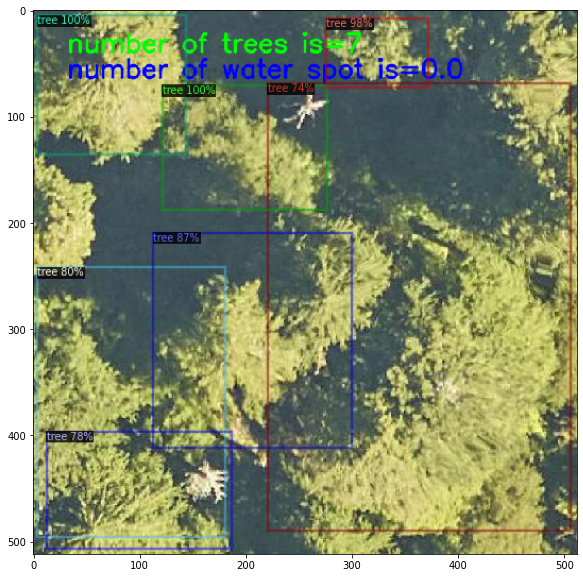

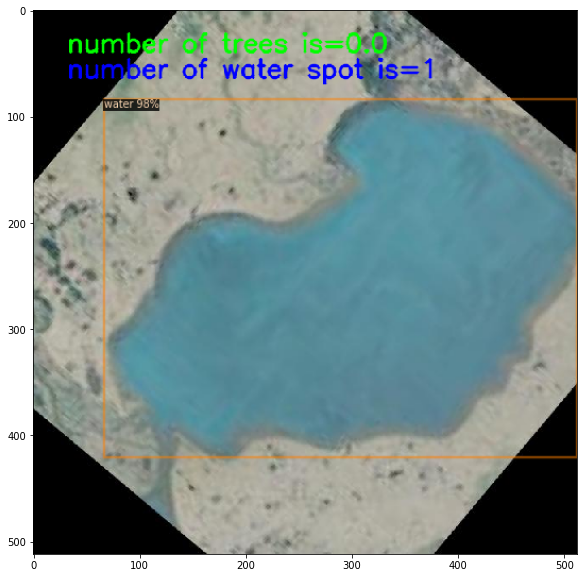

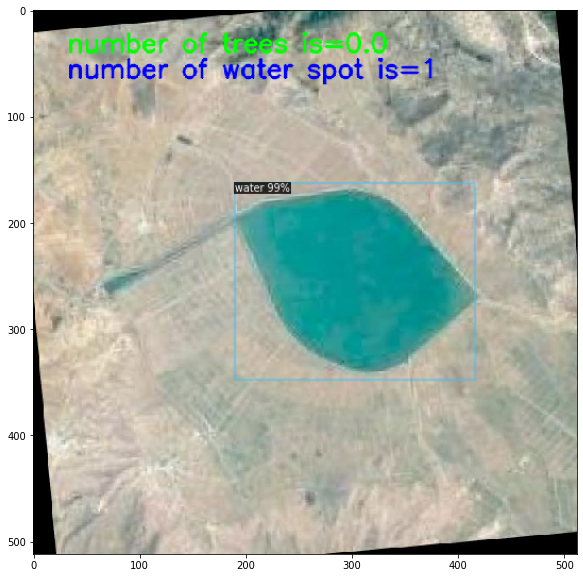

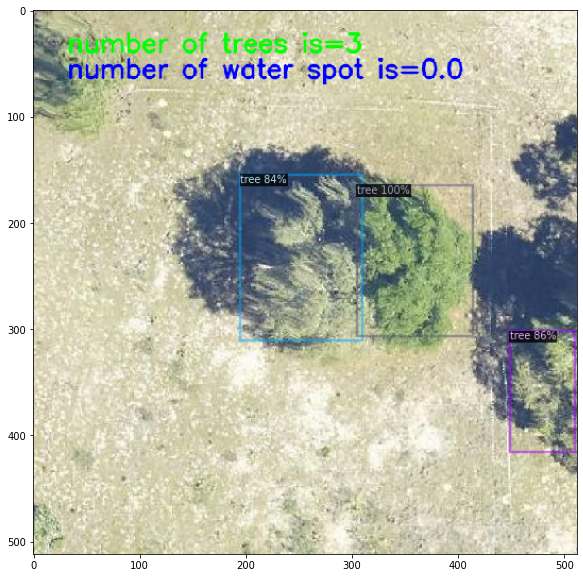

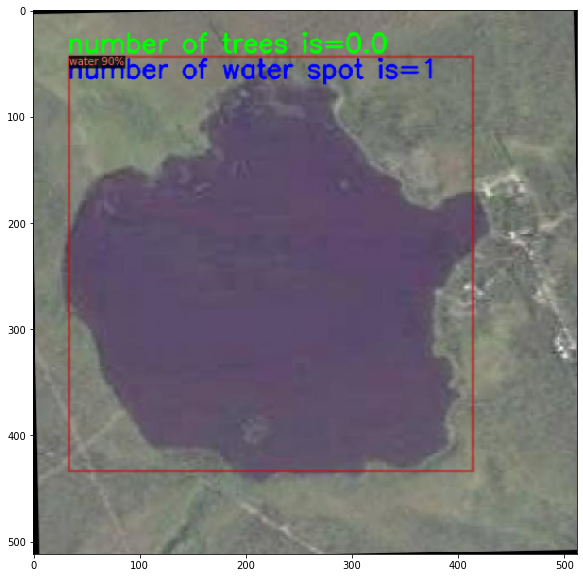

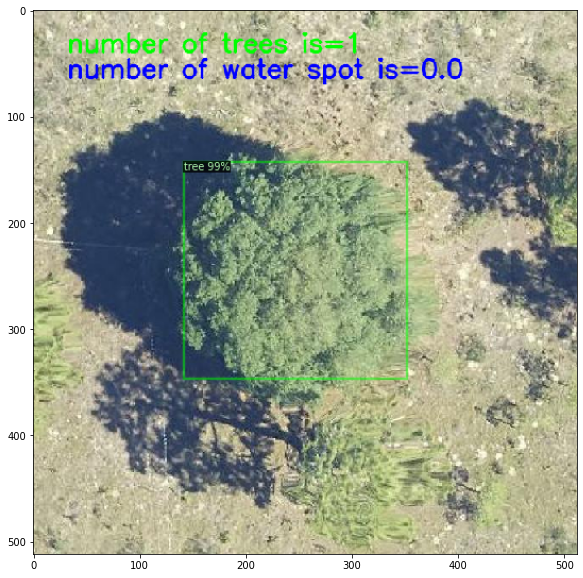

In [96]:
for d in random.sample(test_dataset_dicts, 6):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    counter = []
    water = []
    for key, value in outputs.items():
      tree = value.get('pred_classes')
      for o in tree:
        if o==1:
          counter.append(1)
        else:
          if o==0:
            water.append(1)
              
    cv2.putText(img, 'number of trees is='+str(np.sum(counter)), (40, 50), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img, 'number of water spot is='+str(np.sum(water)), (40, 80), cv2.FONT_HERSHEY_SIMPLEX, 1 , (255, 0, 0), 2, cv2.LINE_AA)    
        #counter.append(len(value))
        #cv2.putText(img, 'Counter='+str(counter), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1 , (255, 0, 0), 2, cv2.LINE_AA)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (20, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [21]:
#print([(k, outputs[k]) for k in outputs])
#counter = []
#for key, value in outputs.items():
    #counter.append(len(value))
#str(counter) 
outputs

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[381.3505, 206.3917, 517.0080, 384.1114],
         [560.9838, 377.7982, 637.7944, 520.6185],
         [244.3202, 193.7941, 387.6442, 388.4757]])), scores: tensor([0.9955, 0.8585, 0.8416]), pred_classes: tensor([1, 1, 1])])}

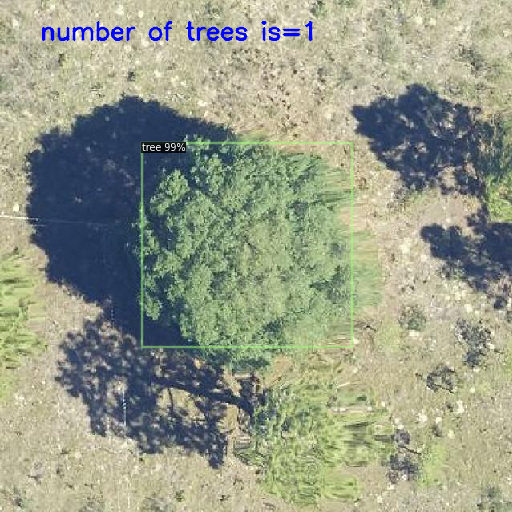

In [67]:
from detectron2.utils.visualizer import ColorMode
import glob
from google.colab.patches import cv2_imshow
for imageName in glob.glob('/content/unnamed_plot_99_competition_resultat_jpg.rf.c42307e0dffab2f6029ff617785c812d.jpg'):
  img2 = cv2.imread(imageName)
  outputss = predictor(img2)
  counterr = []
  

  listt = []
  for key, value in outputss.items():
    #print(value)
    tree = value.get('pred_classes')
    #print(tree)
    for o in tree:
      if o==1:
        listt.append(1)
      else:
        break  
    cv2.putText(img2, 'number of trees is='+str(np.sum(listt)), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1 , (255, 0, 0), 2, cv2.LINE_AA)
        #listt.clear()
        #listt.index
    #print(listt[-1])     
  v = Visualizer(img2[:, :, ::-1],metadata=test_metadata, scale=0.8)
  out = v.draw_instance_predictions(outputss["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  

In [48]:
import operator

#addad=0
listt = []
for key, value in outputss.items():
  #print(value)
  tree = value.get('pred_classes')
  #print(tree)
  for o in tree:
    if o==1:
      listt.append(1)
      #print(len(listt))
      #print(listt)
      sum = np.sum(listt)
print(sum)
      #addad = addad +1
      #addad = operator.add(addad, 1)
      #print(addad)

    #for z in tree:
      #print(z.)
      #print(z)
      #if z.item==1:
        #conunteer +=1
   #print(conunteer)
    #print(len(tree))
  #print(value)
        #counterr.append(len(value))

10


In [90]:
#for i in v.metadata.as_dict()['thing_classes']if i=='tree':
 # print(i)

#[i for i in v.metadata.as_dict()['thing_classes'] if i=='tree']
counterr=[]
for i in v.metadata.as_dict()['thing_classes']:
  if i=='tree':
    print(i)
    for key, value in outputss.items():
          counterr.append(len(value))
          print("tree count=",counterr)
          

        

tree
tree count= [1]


In [26]:
outputss

{'instances': Instances(num_instances=10, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 97.7061, 497.0918, 201.6729, 621.9189],
         [377.6954, 143.2729, 479.7993, 319.1352],
         [436.7039,  65.6562, 503.3839, 133.5166],
         [502.2767, 522.3618, 634.6996, 630.8002],
         [217.1619, 291.2229, 317.0232, 375.3167],
         [ 36.6502,   5.9075, 136.4325, 112.2699],
         [226.6931,  11.3894, 294.8768,  98.1026],
         [184.2738, 163.0617, 285.4729, 260.1521],
         [237.2198, 466.0053, 329.7305, 570.9454],
         [522.6530,  67.4020, 630.5800, 257.5326]], device='cuda:0')), scores: tensor([0.9972, 0.9962, 0.9932, 0.9931, 0.9918, 0.9913, 0.9902, 0.9852, 0.9597,
         0.9186], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')])}

In [ ]:
#print([(k, outputs[k]) for k in outputs])
counter = []
for key, value in outputss.items():
    counter.append(len(value))
str(counter) 

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
from google.colab.patches import cv2_imshow
for imageName in glob.glob('/content/drive/MyDrive/proje/resim_video/a.jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:

from detectron2.config import get_cfg
cfg = get_cfg() 
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")) #Yapılandırma Dosyası
cfg.DATASETS.TRAIN = ("my_train",) 
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.SOLVER.BASE_LR = 0.001 
cfg.SOLVER.GAMMA = 0.05 
cfg.SOLVER.STEPS = [500] 
cfg.TEST.EVAL_PERIOD = 200 
cfg.SOLVER.MAX_ITER = 2000 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.58
test_dataset_dicts = get_data_dicts(data_path+'train', classes)

cfg.merge_from_list(["MODEL.WEIGHTS", "weights.pth"])   # can also load values from a list of str
print(cfg.dump())  # print formatted configs
with open("output.yaml", "w") as f:
  f.write(cfg.dump())   # save config to file

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST: []
  TRAIN:
  - my_train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEV

In [ ]:
!git clone https://github.com/facebookresearch/detectron2


Cloning into 'detectron2'...
remote: Enumerating objects: 14651, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 14651 (delta 26), reused 37 (delta 15), pack-reused 14584
Receiving objects: 100% (14651/14651), 6.01 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (10584/10584), done.


In [ ]:
%run detectron2/demo/demo.py --config-file /content/output.yaml --video-input /content/drive/MyDrive/Facebook.mp4 --confidence-threshold 0.58 --output video-output.mp4 \
  --opts MODEL.WEIGHTS /content/output/model_final.pth
     

[12/17 10:36:55 detectron2]: Arguments: Namespace(confidence_threshold=0.58, config_file='/content/output.yaml', input=None, opts=['MODEL.WEIGHTS', '/content/output/model_final.pth'], output='video-output.mp4', video_input='/content/drive/MyDrive/Facebook.mp4', webcam=False)
[12/17 10:36:56 fvcore.common.checkpoint]: [Checkpointer] Loading from /content/output/model_final.pth ...


100%|██████████| 1780/1780 [06:17<00:00,  4.71it/s]


<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import files
files.download('/content/video-output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

from google.colab import files
files.download('/content/output/model_final.pth')